# SimCLR

Multi-backends version.

In [1]:
# %xmode minimal

import os
import json

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

import os
os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models

import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

# Turn off logging for TF
import logging
tf.get_logger().setLevel(logging.ERROR)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

from keras import layers, models, ops, losses, metrics

from keras.applications import resnet

# from keras.applications import vgg16

2024-06-18 18:09:36.487979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# tf.config.experimental_run_functions_eagerly(True)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())


In [3]:
import dpmhm
# dpmhm.datasets.get_dataset_list()
from dpmhm.datasets import preprocessing, transformer, feature, utils
# from dpmhm.models import byol, simclr

workdir = Path("/home/han/tmp/SimCLR/")
os.makedirs(workdir, exist_ok=True)

In [4]:
def NT_Xent_loss(zi, zj, tau:float=0.5, axis:int=1) -> float:
    """Normalized Temperature-scaled Cross Entropy Loss.

    We modify the original definition by excluding also the term of index `j` from the denominator. This is closer to the initial aim of NT-Xent to pull together positive pairs (between `i` and `j`) while pushing apart negative pairs (not including `j`).

    Parameters
    ----------
    zi
        Anchor samples
    zj
        Augmented samples
    tau, optional
        Temperature, by default 0.5. A small temperature implies a sharper distribution in the feature space.
    axis, optional
        Axis of feature, by default 1
    """
    zi = ops.normalize(zi, axis=axis)
    zj = ops.normalize(zj, axis=axis)
    # print('shape after=', zi.shape, zj.shape)

    # Cosine similarity
    # between anchor - anchor
    Sii = ops.matmul(zi, ops.transpose(zi)) / tau
    # between anchor - augmented
    Sij = ops.matmul(zi, ops.transpose(zj)) / tau

    P = ops.diag(Sij)
    N = Sii - ops.diag(Sii) + Sij - ops.diag(Sij)

    return ops.sum(ops.logsumexp(N, axis=axis) - P)


def _loss(y_true, y_pred):
    y1, y2 = y_pred[0], y_pred[1]
    # y1 = ops.take(y_pred, 0, axis=0)
    # y2 = ops.take(y_pred, 1, axis=0)
    return NT_Xent_loss(y1, y2) + NT_Xent_loss(y2, y1)

# _loss = lambda y_true, y_pred: NT_Xent_loss(y_pred[0], y_pred[1]) + NT_Xent_loss(y_pred[1], y_pred[0])

In [5]:
class SimCLR(keras.Model):
    def __init__(self, input_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self._encoder = resnet.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
        self._encoder.trainable = False

        self. _projector = models.Sequential([
            # A dense layer applies only on the last dimension while preserving all other dimensions as batch.
            layers.Flatten(name='flatten'),
            layers.Dense(256, activation='relu', name='fc1'),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu', name='fc2'),
            layers.BatchNormalization(),
            layers.Dense(64, activation=None, name='fc3'),
        ], name='Projection_head')

    def call(self, inputs, training=True):
        x1, x2 = inputs  # ok if inputs is tuple, error in tensorflow's autograph mode: iterating on a tensor
        # x1, x2 = inputs[0], inputs[1]  # not considered as iterating on a tensor
        #
        # if `inputs` is packed into a single tensor
        # x1 = ops.take(inputs, 0, axis=1)
        # x2 = ops.take(inputs, 1, axis=1)

        y1 = self._projector(self._encoder(x1), training=training)
        y2 = self._projector(self._encoder(x2), training=training)

        # return y1, y2  # error: only y1 is passed to the loss function
        return ops.stack([y1, y2])

## Load Data

In [6]:
ds_name = 'CWRU'

dpmhm.datasets.query_parameters(ds_name)

{'signal': {'DE': 1, 'FE': 1, 'BA': 1},
 'sampling_rate': [12000, 48000],
 'keys': {'FaultLocation': {'DriveEnd', 'FanEnd', 'None'},
  'FaultComponent': {'Ball',
   'InnerRace',
   'None',
   'OuterRace12',
   'OuterRace3',
   'OuterRace6'},
  'FaultSize': {0, 0.007, 0.014, 0.021, 0.028}},
 'filters': {'LoadForce': {0, 1, 2, 3}},
 'type': 'initiated',
 'split': ['train']}

In [7]:
ds0 = tfds.load(
    ds_name,
    # split='',
    # split=['train[:75%]', 'train[75%:]'],
    # split=[split1, split2],
    split='all',
    # download=True,  #
    # with_info=True,
    # batch_size=-1,  # load the whole dataset into a single batch
)

# ds0 = ds_all['train']
# ds_size = utils.get_dataset_size(ds0)

channels = ['DE', 'FE', 'BA']  # will rule out the normal data

keys = ['FaultComponent', 'FaultSize', 'FaultLocation']

# Feature extractor
_func = lambda x, sr: feature.spectral_features(
    x, sr, 'spectrogram',
    time_window=0.025,
    hop_step=0.0125,
    normalize=False,
    to_db=True)[0]

# _func = lambda x, sr: feature.spectral_features(
#     x, sr, 'melspectrogram',
#     time_window=0.025, hop_step=0.0125, normalize=False,
#     feature_kwargs={'n_mels':128})[0]

compactor = transformer.DatasetCompactor(ds0, keys=keys, channels=channels)
labels = list(compactor.full_label_dict.keys())

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# product = transformer.Product(specaugment.dataset, keys=['FileName'], positive=True)

# slider = transformer.WindowSlider(extractor.dataset, window_shape=64, downsample=64)
# # fp = tempfile.mkdtemp()
# # slider.serialize(str(workdir), compression='GZIP')
# slider.dataset = tf.data.Dataset.load(str(workdir), compression='GZIP')

# slider.dataset.cardinality()
# preproc = preprocessing.get_mapping_supervised(labels)
# ds1 = utils.restore_shape(
#     specaugment.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)
# )

2024-06-18 18:09:38.324186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:09:38.600347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:09:38.870577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### SpecAugment and Paired dataset

For any spectral sample `x`, we apply the spectrogram augmentation provided in `transformer` and build a paired dataset of form `(x1, x2)` for SSL.

Notably, the paired dataset preserves randomness: a paired sample `(x1, x2)` is two randomly transformed version of a common `x`. Let's check this.

Alternatively, the spectrogram augmentation can be implemented also via keras preprocessing layers as follows 

```python
layer_zoom = keras.layers.RandomZoom((-.5,.5), fill_mode='reflect')
layer_flip = keras.layers.RandomFlip(mode='horizontal')
layer_crop = keras.layers.RandomCrop(64, 64)

layer_flip(layer_crop(layer_zoom(X)))
```

2024-06-18 18:09:40.891371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


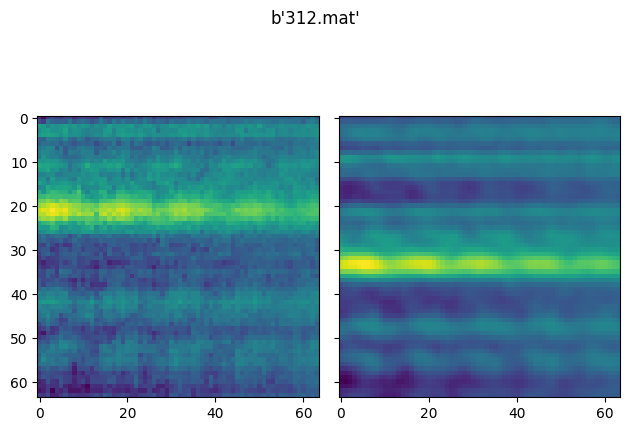

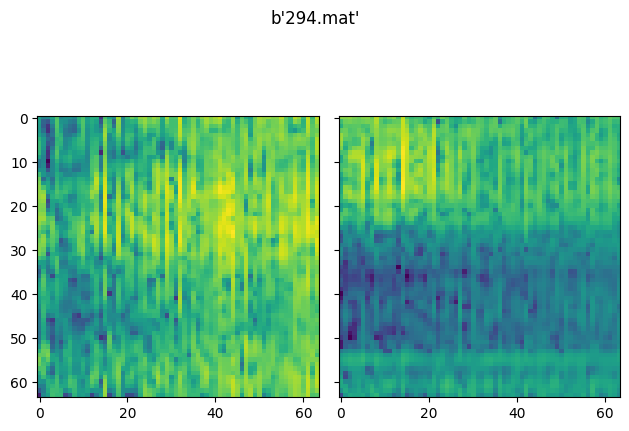

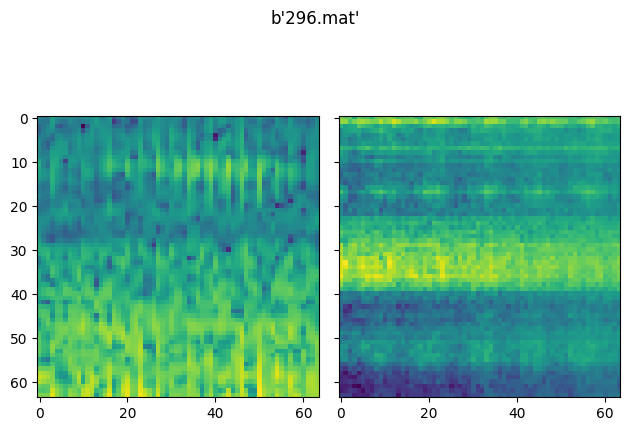

In [8]:
specaugment = transformer.SpecAugment(extractor.dataset)

ds1 = specaugment.dataset
# Paired dataset
ds2 = tf.data.Dataset.zip(ds1, ds1)

for e1, e2 in ds2.take(3):
    assert(e1['metadata']==e2['metadata'])
    X1 = e1['feature'][0]
    X2 = e2['feature'][0]

    fig, axes = plt.subplots(1,2,sharey=True)
    axes[0].imshow(X1)
    axes[1].imshow(X2)
    fig.suptitle(e1['metadata']['FileName'].numpy())
    fig.tight_layout()

### Dataset with fake labels

The paired dataset of element type `(x1, x2)` passed to the SimCLR model will be transformed to `(y1, y2)`. Unfortunately the later incompatible with the loss function `loss(y_true, y_pred)` accepted by Keras. Actually, there is no `y_true` in our case and `y_pred` should be `(y1, y2)`. 

One solution (also put forward by the official documentation of Keras) is to customize the method `train_step()` which is backend dependent, like in

https://keras.io/guides/custom_train_step_in_tensorflow/

 A simpler solution avoids the customization and only needs to adapt `call()` and the loss function, like follows

1. From the original paired dataset build a dataset of type `((x1, x2), fake_label)` as input to the SimCLR model's `.call()`. Optionally the part `(x1, x2)` can be stacked in a single tensor (possibly of higher dimension) to avoid any implicite compile time error, using `.map()` on `tf.stack([x1, x2])`.
2. In `.call(inputs)` separate `x1` and `x2` from `inputs` as `x1, x2 = inputs[0], inputs[1]`. This is safer than `x1, x2 = inputs` which may complain when use Tensorflow as backend. For stacked inputs, use instead `ops.take()`. On the other hand, the output of `.call()` must be a single tensor like `ops.stack([y1, y2])`.
3. The loss function's signature is always `loss(y_true, y_pred)`, although it doesn't use the fake label `y_true` at all. `y1` and `y2` needed by the original loss are obtained again by splitting `y_pred` using `ops.take()`. 

Then one can call `model.fit()` on the dataset `((x1, x2), fake_label)` for training, independant of the backend.

The logic behind this solution is that the `Model` class in Keras is actually designed for supervised learning, of type `y=f(x)`. A customized Keras model implements `f` in the method `.call(x)`, which should not be confused with `.fit(x,y)`. The argument `inputs` to `.call(inputs)` can be a tuple, but the output has to be a single tensor (if the output has several terms then only the first is passed to the loss function). The type of dataset passed to `model.fit()` has always to be `(x,y)`: no matter how many actual terms in `x` (and `y`), they need to be packed in a single tensor properly. The loss function takes `(y_true, y_pred)` with `y_true` from the dataset and `y_pred` from the output of `.call()`. Any deviation from this setting should be adapted, like the solution outlined above.

Let's remove all irrelevant information and keep only the field `'feature'`, and make a ready-to-use paired dataset with a fake label.

In [9]:
specaugment = transformer.SpecAugment(extractor.dataset)

# To channel last format
ds1 = utils.restore_shape(
    specaugment.dataset.map(lambda x: tf.transpose(x['feature'], [1,2,0]), num_parallel_calls=tf.data.AUTOTUNE),
)
input_shape = ds1.element_spec.shape

# Paired dataset
ds2 = tf.data.Dataset.zip(ds1, ds1)
# ds2 = tf.data.Dataset.zip(ds1, ds1, ds1)  # or even more...
# eles = list(ds2.take(10).as_numpy_iterator())

ds2.element_spec
# ds2_size = utils.get_dataset_size(ds2)
# ds2 = ds2.apply(tf.data.experimental.assert_cardinality(ds2_size))

2024-06-18 18:09:41.830671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None))

In [10]:
# Construct a dataset with fake labels, following the logic of Keras
def func(cst):
    def _gen():
        while True:
            yield cst
    return _gen

dg = tf.data.Dataset.from_generator(func(None), output_types=tf.float32, output_shapes=())
# dg = tf.data.Dataset.from_generator(func(1.), output_signature=tf.TensorSpec(shape=(None)))  # equivalent

# list(dg.take(10))
# or `list(dg.repeat().take(10))` if no `while` loop in the generator.

ds = tf.data.Dataset.zip(ds2, dg)

Equivalently, just use the provided method `utils.twins_dataset_ssl()`.

In [11]:
specaugment = transformer.SpecAugment(extractor.dataset)

ds, input_shape = utils.twins_dataset_ssl(specaugment.dataset, fake_label=True)

ds.element_spec

2024-06-18 18:09:42.421424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


((TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [12]:
ds = utils.restore_cardinality(ds)
ds_size = int(ds.cardinality())  # utils.get_dataset_size(ds)

ds_size

2024-06-18 18:09:46.742143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


97

## SimCLR model

In [13]:
splits = {'train':0.7, 'val':0.2, 'test':0.1}

ds_split = utils.split_dataset(ds, splits, ds_size=ds_size)

batch_size = 10

ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size, drop_remainder=True)
ds_test = ds_split['test'].batch(1, drop_remainder=True)

ds_train.element_spec

((TensorSpec(shape=(10, 64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(10, 64, 64, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(10,), dtype=tf.float32, name=None))

In [14]:
model = SimCLR(input_shape)

# y1, y2 = model(*ds_train.take(1))

# x1 = layers.Input(shape=input_shape)
# x2 = layers.Input(shape=input_shape)
# model = models.Model(inputs=(x1, x2), outputs=simclr_model([x1, x2]))

# model(*ds_train.take(1))

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=_loss
)

model.summary()

Model: "sim_clr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Projection_head (Sequential)    │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - loss: 6.9124

2024-06-18 18:10:09.208755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:10:13.820833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 6.9296 - val_loss: 8.4720
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 12.8761

2024-06-18 18:10:25.864272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:10:30.300608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 12.5508 - val_loss: 7.6275
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 11.5524

2024-06-18 18:10:35.801590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:10:40.545181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 11.0819 - val_loss: 8.7005
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 5.6673

2024-06-18 18:10:46.104997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:10:50.567205: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-06-18 18:10:50.568485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 5.4876 - val_loss: 2.0394
Epoch 5/100


2024-06-18 18:10:55.142388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 10.1115

2024-06-18 18:10:56.054813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:11:00.547146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 9.6603 - val_loss: 5.7913
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 4.5024

2024-06-18 18:11:05.886791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:11:10.474296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 4.6484 - val_loss: 4.0656
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 5.4390

2024-06-18 18:11:15.769208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:11:20.326042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 5.5558 - val_loss: -0.6790
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 4.2635

2024-06-18 18:11:25.390925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:11:29.634606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 4.4252 - val_loss: 3.1120
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 4.6496

2024-06-18 18:11:34.774161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:11:38.903735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 4.2750 - val_loss: -3.4895
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 2.6769

2024-06-18 18:11:44.437200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:11:48.955114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 2.8174 - val_loss: 2.0947
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: -0.5508

2024-06-18 18:11:54.586981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:11:58.724273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -0.4814 - val_loss: 0.4344
Epoch 12/100


2024-06-18 18:12:03.403751: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 8.7092

2024-06-18 18:12:04.365458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:12:08.822988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 8.1540 - val_loss: 6.2128
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.6313

2024-06-18 18:12:15.183445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:12:19.675334: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-06-18 18:12:19.677475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.7511 - val_loss: -1.8104
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -2.0619

2024-06-18 18:12:25.013301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:12:29.252134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -2.2002 - val_loss: 4.6767
Epoch 15/100


2024-06-18 18:12:33.648918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: -0.8343

2024-06-18 18:12:34.615961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:12:39.440353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -0.9387 - val_loss: -14.5494
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: -3.6555

2024-06-18 18:12:44.952748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:12:49.357946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: -3.5393 - val_loss: -2.4177
Epoch 17/100


2024-06-18 18:12:54.782265: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: -1.5360

2024-06-18 18:12:55.710395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:13:00.054829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -1.7341 - val_loss: -9.3314
Epoch 18/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 1.8624

2024-06-18 18:13:05.666234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 1.6219

2024-06-18 18:13:10.098532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 1.4500 - val_loss: 16.3947
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: -2.4136

2024-06-18 18:13:15.758350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:13:20.251225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -2.5383 - val_loss: -0.1033
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: -6.6573

2024-06-18 18:13:25.556171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:13:29.606840: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-06-18 18:13:29.608247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -6.4250 - val_loss: 4.5819
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: -1.6437

2024-06-18 18:13:35.337827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:13:39.544389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -0.9032 - val_loss: 2.8966
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: -5.5454

2024-06-18 18:13:45.004360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:13:48.838561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 957ms/step - loss: -5.3519 - val_loss: 2.6861
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.3586

2024-06-18 18:13:54.224715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:13:58.203296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 992ms/step - loss: 0.4053 - val_loss: -2.2514
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: -6.7801

2024-06-18 18:14:03.717092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:14:07.764044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 996ms/step - loss: -6.7306 - val_loss: -1.5553
Epoch 25/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: -6.8830

2024-06-18 18:14:13.274771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: -6.6996

2024-06-18 18:14:17.779945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -6.5686 - val_loss: -5.4542
Epoch 26/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: -3.1053

2024-06-18 18:14:23.330822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:14:27.827431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.6466 - val_loss: -0.1497
Epoch 27/100


2024-06-18 18:14:32.143922: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: -6.3168

2024-06-18 18:14:33.138493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: -5.8908

2024-06-18 18:14:37.491990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -5.5865 - val_loss: 15.1315
Epoch 28/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: -8.2304

2024-06-18 18:14:42.951480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:14:47.442141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.7805 - val_loss: 4.4031
Epoch 29/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: -0.6011

2024-06-18 18:14:52.832610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:14:57.269518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -0.9942 - val_loss: 6.1328
Epoch 30/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: -4.0056

2024-06-18 18:15:02.658658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:15:07.189625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.9247 - val_loss: -13.0043
Epoch 31/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: -2.2257

2024-06-18 18:15:12.418038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:15:16.833029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -2.7076 - val_loss: 2.5819
Epoch 32/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: -3.9103

2024-06-18 18:15:22.124448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:15:26.489272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.8572 - val_loss: 3.1211
Epoch 33/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: -5.6054

2024-06-18 18:15:31.818778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:15:36.383552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -5.4585 - val_loss: -1.9249
Epoch 34/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -4.8188

2024-06-18 18:15:41.314850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:15:45.420941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -4.9595 - val_loss: 0.2965
Epoch 35/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: -0.8020

2024-06-18 18:15:51.038878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:15:55.491702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: -0.8595 - val_loss: -2.6825
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: -2.3562

2024-06-18 18:16:01.927192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:16:06.430230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -2.7804 - val_loss: -8.9331
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.4411

2024-06-18 18:16:11.673126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:16:16.004676: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-06-18 18:16:16.007818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -0.1042 - val_loss: -16.1886
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: -3.5952

2024-06-18 18:16:21.540905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:16:25.870780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.7506 - val_loss: -10.4527
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: -5.3716

2024-06-18 18:16:31.110006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:16:35.595600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -5.5834 - val_loss: 3.4566
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: -3.5178

2024-06-18 18:16:41.234972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:16:45.612351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.7368 - val_loss: -12.6320
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: -6.8261

2024-06-18 18:16:51.112069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:16:55.666424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.1106 - val_loss: 7.6272
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: -8.7126

2024-06-18 18:17:00.880629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:17:05.390775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -8.2087 - val_loss: -10.5751
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: -5.0250

2024-06-18 18:17:11.048362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:17:15.381954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -4.6601 - val_loss: -4.9451
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: -8.1202

2024-06-18 18:17:20.946581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:17:25.417323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -8.2154 - val_loss: -7.8549
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: -6.7602

2024-06-18 18:17:30.514702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:17:34.705780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -6.4242 - val_loss: 0.7701
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: -6.3810

2024-06-18 18:17:39.839261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:17:44.534435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -6.7210 - val_loss: -8.1021
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -8.8549

2024-06-18 18:17:50.028695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:17:54.412878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -8.8903 - val_loss: 3.1441
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 2.6957

2024-06-18 18:17:59.385766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:18:04.027094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 2.5333 - val_loss: -8.4327
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: -1.3508

2024-06-18 18:18:09.538067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:18:13.981548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -1.3025 - val_loss: -15.0472
Epoch 50/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 1.3635

2024-06-18 18:18:19.357101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:18:23.965781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 1.0969 - val_loss: -3.7479
Epoch 51/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: -0.7390

2024-06-18 18:18:29.115943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:18:33.445726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -1.0481 - val_loss: -10.5202
Epoch 52/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: -11.6030

2024-06-18 18:18:38.889366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:18:43.178304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -11.3790 - val_loss: -13.1513
Epoch 53/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: -10.5764

2024-06-18 18:18:48.657926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:18:53.211969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.1003 - val_loss: 4.2854
Epoch 54/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -7.4156

2024-06-18 18:18:58.548349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:19:02.966849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.8462 - val_loss: -7.0540
Epoch 55/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: -3.1756

2024-06-18 18:19:08.422394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:19:12.869915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.2910 - val_loss: 6.9765
Epoch 56/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: -11.6347

2024-06-18 18:19:18.079420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:19:22.579817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -11.3826 - val_loss: 4.3485
Epoch 57/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: -3.6050

2024-06-18 18:19:27.908777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:19:32.062075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -3.3435 - val_loss: -3.5171
Epoch 58/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: -5.5408

2024-06-18 18:19:37.522556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:19:41.710251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -5.4626 - val_loss: -6.0188
Epoch 59/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: -10.9216

2024-06-18 18:19:47.062815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:19:51.739654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.2020 - val_loss: 1.2489
Epoch 60/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: -6.6877

2024-06-18 18:19:57.290239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: -6.0780

2024-06-18 18:20:01.884258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -5.6425 - val_loss: -7.5831
Epoch 61/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: -5.9261

2024-06-18 18:20:07.410244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: -6.1239

2024-06-18 18:20:11.715078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -6.2652 - val_loss: -20.7139
Epoch 62/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: -8.2633

2024-06-18 18:20:17.259414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:20:21.525578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.7614 - val_loss: 10.4310
Epoch 63/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: -11.2380

2024-06-18 18:20:27.154908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:20:31.546869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.9594 - val_loss: -5.2369
Epoch 64/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -3.5057

2024-06-18 18:20:36.591651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:20:41.050668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -3.7862 - val_loss: -14.4639
Epoch 65/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: -12.7207

2024-06-18 18:20:46.076917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:20:50.584033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -12.2636 - val_loss: 4.0351
Epoch 66/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: -7.0537

2024-06-18 18:20:55.961130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:21:00.569365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.0030 - val_loss: 8.0344
Epoch 67/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: -5.1857

2024-06-18 18:21:05.971347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:21:10.215353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -5.1361 - val_loss: -8.5080
Epoch 68/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: -12.0106

2024-06-18 18:21:15.602083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:21:20.166441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -11.9782 - val_loss: -11.0411
Epoch 69/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: -7.8373

2024-06-18 18:21:25.564035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:21:30.059666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -8.0586 - val_loss: -9.2091
Epoch 70/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: -11.6791

2024-06-18 18:21:35.280580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:21:39.752524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -11.2324 - val_loss: -2.8709
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: -4.0821

2024-06-18 18:21:45.192102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:21:49.447517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.9385 - val_loss: -13.9857
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: -2.8128

2024-06-18 18:21:54.898102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:21:59.246066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.0204 - val_loss: -3.8005
Epoch 73/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -9.5274 

2024-06-18 18:22:04.780364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:22:09.340923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -9.0394 - val_loss: -7.1085
Epoch 74/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: -6.9821

2024-06-18 18:22:14.821417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:22:19.212981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.0190 - val_loss: -1.6739
Epoch 75/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: -9.0720

2024-06-18 18:22:24.822734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:22:29.114348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -8.9116 - val_loss: -2.5727
Epoch 76/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: -10.2082

2024-06-18 18:22:34.418572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:22:38.819151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.1673 - val_loss: 4.7921
Epoch 77/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: -5.6090

2024-06-18 18:22:44.469715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:22:48.978073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -5.7357 - val_loss: -18.5402
Epoch 78/100


2024-06-18 18:22:49.640405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 1451951 bytes after encountering the first element of size 1451951 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-06-18 18:22:53.507894: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 983080 bytes after encountering the first element of size 983080 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: -8.1490

2024-06-18 18:22:54.394828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:22:58.845164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: -8.1786 - val_loss: -11.7750
Epoch 79/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: -7.7636

2024-06-18 18:23:05.465038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:23:09.975123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.3488 - val_loss: -9.3819
Epoch 80/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: -10.5916

2024-06-18 18:23:15.333863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:23:19.782994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.5031 - val_loss: -5.2485
Epoch 81/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: -11.0255

2024-06-18 18:23:25.179001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:23:29.814211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.8803 - val_loss: 3.1710
Epoch 82/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: -8.5471

2024-06-18 18:23:35.169310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:23:39.666190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: -8.3667 - val_loss: -6.5445
Epoch 83/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: -10.8005

2024-06-18 18:23:46.127786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:23:50.619747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.7375 - val_loss: -11.2866
Epoch 84/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: -9.7341

2024-06-18 18:23:56.021192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:24:00.460076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -9.6780 - val_loss: -5.7891
Epoch 85/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -11.5649

2024-06-18 18:24:05.715343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:24:09.982304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -11.6615 - val_loss: -4.4442
Epoch 86/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: -10.4848

2024-06-18 18:24:15.563913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:24:19.625686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.6551 - val_loss: -13.1193
Epoch 87/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: -7.7198

2024-06-18 18:24:25.087241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:24:29.518882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -7.5616 - val_loss: -10.3428
Epoch 88/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: -3.0326

2024-06-18 18:24:34.653273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:24:39.205736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -3.2173 - val_loss: -13.3038
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: -6.3086

2024-06-18 18:24:44.576247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:24:49.111768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -6.2965 - val_loss: -17.9752
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: -0.0039

2024-06-18 18:24:54.384939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:24:58.414585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 995ms/step - loss: -0.4178 - val_loss: -2.1213
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: -10.4912

2024-06-18 18:25:04.050425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:25:08.480569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.3589 - val_loss: -1.7054
Epoch 92/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: -3.4555

2024-06-18 18:25:13.884675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:25:17.990408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: -3.4892 - val_loss: -9.0304
Epoch 93/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: -4.1257

2024-06-18 18:25:24.751798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:25:28.727905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 992ms/step - loss: -4.1617 - val_loss: -7.7968
Epoch 94/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: -11.3511

2024-06-18 18:25:34.227648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: -10.8253

2024-06-18 18:25:38.959239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.4498 - val_loss: -1.1790
Epoch 95/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: -7.8682

2024-06-18 18:25:44.237631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:25:48.569342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -8.0303 - val_loss: 4.1570
Epoch 96/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: -8.4884

2024-06-18 18:25:54.045460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:25:58.346658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -8.9057 - val_loss: 8.2640
Epoch 97/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: -10.6313

2024-06-18 18:26:03.652742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:26:08.057922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -10.4899 - val_loss: -11.5326
Epoch 98/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: -3.7386

2024-06-18 18:26:13.437820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:26:17.543765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -4.1425 - val_loss: -6.6096
Epoch 99/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: -13.9096

2024-06-18 18:26:23.060393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:26:27.711043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: -13.6365 - val_loss: -5.7103
Epoch 100/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: -11.7418

2024-06-18 18:26:33.018851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 18:26:37.132759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: -11.8087 - val_loss: 0.4843


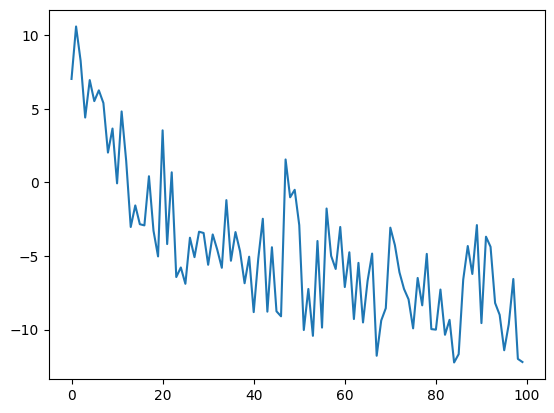

In [15]:
hh = model.fit(ds_train,
               validation_data=ds_val,
               epochs=100)

plt.plot(hh.history['loss'])

### Supervised fine tuning

From the trained SimCLR model, we extract the feature transformation part which includes the base encoder and the first two dense layers of the projection head. 

In [16]:
x = layers.Input(input_shape)

# same same
# _proj = models.Model(inputs=model._projector.inputs, outputs=model._projector.layers[3].output)
_proj = models.Model(inputs=model._projector.layers[0].input, outputs=model._projector.layers[3].output)

# _proj.summary()  # shows a concrete value for batch

f = _proj(model._encoder(x))

model_feature = models.Model(inputs=x, outputs=f, name='SimCLR_feature')

model_feature.summary()  # shows `None` for batch

Model: "SimCLR_feature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 128)            │       558,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,146,176 (92.11 MB)

 Trainable params: 557,952 (2.13 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

#### Classfication head and fine tuning

We add a classification head to the feature transformation network and fine tune the model on some new data.

In [72]:
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(64,64))
# fp = tempfile.mkdtemp()
# window.serialize(str(workdir), compression='GZIP')
# window.dataset = tf.data.Dataset.load(str(workdir), compression='GZIP')

preproc = preprocessing.get_mapping_supervised(labels)

splits = {'train':0.7, 'val':0.2, 'test':0.1}
batch_size = 64

n_classes = len(labels) + 1

In [73]:
dw = utils.restore_shape(
    window.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE),
    key=0
)

dw_split = utils.split_dataset(
    dw, splits, 
    # ds_size=dw_size, 
    # labels=np.arange(n_classes)
)

dw_train = dw_split['train']\
    .shuffle(dw_size, reshuffle_each_iteration=True)\
    .repeat()\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val'].repeat().batch(batch_size, drop_remainder=True)
dw_test = dw_split['test'].batch(batch_size, drop_remainder=True)

2024-06-18 22:47:36.336503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:47:36.628718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:47:36.877716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:47:39.408311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:47:39.412625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The classification head here is a simple MLP. The weights of the feature transformation network are frozen for the training.

In [ ]:
model_feature.trainable = False

class_head = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_classes) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fine = models.Model(inputs=x, outputs=class_head(model_feature(x)))

model_fine.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [25]:
hh = model_fine.fit(
    dw_train,
    validation_data=dw_val,
    epochs=10
)

Epoch 1/10


2024-06-18 22:00:06.579722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:00:11.752229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.7895 - sparse_categorical_accuracy: 0.7663

2024-06-18 22:01:04.898604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.7893 - sparse_categorical_accuracy: 0.7664

2024-06-18 22:01:10.211262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:01:26.443051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 80s 411ms/step - loss: 0.7891 - sparse_categorical_accuracy: 0.7665 - val_loss: 0.6880 - val_sparse_categorical_accuracy: 0.8022
Epoch 2/10


2024-06-18 22:01:31.782949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.6119 - sparse_categorical_accuracy: 0.8167

2024-06-18 22:02:23.311512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.6118 - sparse_categorical_accuracy: 0.8167

2024-06-18 22:02:28.831251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:02:42.860830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 76s 393ms/step - loss: 0.6117 - sparse_categorical_accuracy: 0.8167 - val_loss: 0.5011 - val_sparse_categorical_accuracy: 0.8472
Epoch 3/10


2024-06-18 22:02:48.256063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.5107 - sparse_categorical_accuracy: 0.8469

2024-06-18 22:03:38.858683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.5106 - sparse_categorical_accuracy: 0.8469

2024-06-18 22:03:44.278436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:03:58.220246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 75s 395ms/step - loss: 0.5105 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.4407 - val_sparse_categorical_accuracy: 0.8697
Epoch 4/10


2024-06-18 22:04:03.645383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.4333 - sparse_categorical_accuracy: 0.8713

2024-06-18 22:04:54.939011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8713

2024-06-18 22:05:00.209964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:05:14.250770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 76s 399ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8713 - val_loss: 0.3545 - val_sparse_categorical_accuracy: 0.8975
Epoch 5/10


2024-06-18 22:05:19.887105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.3763 - sparse_categorical_accuracy: 0.8860

2024-06-18 22:06:10.820527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.3763 - sparse_categorical_accuracy: 0.8860

2024-06-18 22:06:16.215612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:06:30.071623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 76s 396ms/step - loss: 0.3763 - sparse_categorical_accuracy: 0.8860 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.8981
Epoch 6/10


2024-06-18 22:06:35.394778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3353 - sparse_categorical_accuracy: 0.8956

2024-06-18 22:07:24.933594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3353 - sparse_categorical_accuracy: 0.8956

2024-06-18 22:07:30.216677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:07:44.233583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 74s 389ms/step - loss: 0.3353 - sparse_categorical_accuracy: 0.8956 - val_loss: 0.2944 - val_sparse_categorical_accuracy: 0.9084
Epoch 7/10


2024-06-18 22:07:49.831970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3064 - sparse_categorical_accuracy: 0.9076

2024-06-18 22:08:39.477198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3064 - sparse_categorical_accuracy: 0.9076

2024-06-18 22:08:44.893281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:08:58.465833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 74s 388ms/step - loss: 0.3064 - sparse_categorical_accuracy: 0.9075 - val_loss: 0.2573 - val_sparse_categorical_accuracy: 0.9259
Epoch 8/10


2024-06-18 22:09:03.781418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.2883 - sparse_categorical_accuracy: 0.9109

2024-06-18 22:09:54.531223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.2883 - sparse_categorical_accuracy: 0.9109

2024-06-18 22:09:59.893396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:10:13.792376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 75s 396ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.2298 - val_sparse_categorical_accuracy: 0.9325
Epoch 9/10


2024-06-18 22:10:19.185287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.2675 - sparse_categorical_accuracy: 0.9155

2024-06-18 22:11:10.295008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.2675 - sparse_categorical_accuracy: 0.9155

2024-06-18 22:11:15.686673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:11:29.460408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 76s 397ms/step - loss: 0.2675 - sparse_categorical_accuracy: 0.9155 - val_loss: 0.2244 - val_sparse_categorical_accuracy: 0.9328
Epoch 10/10


2024-06-18 22:11:34.743218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.2310 - sparse_categorical_accuracy: 0.9280

2024-06-18 22:12:27.161809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.2310 - sparse_categorical_accuracy: 0.9280

2024-06-18 22:12:33.604451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 22:12:48.229442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 416ms/step - loss: 0.2310 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.2063 - val_sparse_categorical_accuracy: 0.9413


In [28]:
model_fine.evaluate(dw_test)

2024-06-18 22:14:38.280661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.2115 - sparse_categorical_accuracy: 0.9405

2024-06-18 22:14:45.099446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - loss: 0.2106 - sparse_categorical_accuracy: 0.9409


[0.19973041117191315, 0.9449999928474426]

### Few-shot learning

In few-shot learning the number of new data per category is limited. We can prepare the data for few-shot learning by splitting separately data of each category.

However for unknown reasons, the performance of the few-shot split seems to be very low compared to the normal split.

In [80]:
window = transformer.WindowSlider(
    extractor.dataset, 
    window_size=(64,64), 
    hop_size=(64, 64)
    # hop_size=(32, 32)
)

preproc = preprocessing.get_mapping_supervised(labels)

splits = {'train':0.2, 'val':0.7, 'test':0.1}
batch_size = 64

n_classes = len(labels) + 1

In [ ]:
# Only for demonstration, here we apply the preprocessing after the split.
dw_split = utils.split_dataset(
    dw, splits, 
    labels=labels
)

dw_train = dw_split['train']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(dw_size, reshuffle_each_iteration=True)\
    .repeat()\
    .batch(batch_size, drop_remainder=True)\
    .prefetch(tf.data.AUTOTUNE)
dw_val = dw_split['val']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .repeat()\
    .batch(batch_size, drop_remainder=True)
dw_test = dw_split['test']\
    .map(preproc, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(batch_size, drop_remainder=True)

# for k, dv in dw_split.items():
#     dv.save(str(workdir/f'fs_split_{k}'))

# %time eles = list(dw_train.take(10))

In [85]:
model_feature.trainable = False

class_head = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(n_classes) # nb labels
], name='Classification_head')

x = layers.Input(input_shape)

model_fs = models.Model(inputs=x, outputs=class_head(model_feature(x)))

model_fs.compile(
    optimizer=keras.optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

In [ ]:
hh = model_fs.fit(
    dw_train,
    validation_data=dw_val,
    epochs=10
)

2024-06-18 23:23:06.103741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:23:07.827731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:23:09.564491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:23:11.245902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:23:12.950104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:23:14.649688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:23:16.366624: W tensorflow/core/framework/local_rendezvous.cc:404] L

Epoch 1/10


2024-06-18 23:25:46.157614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:25:47.963331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:25:49.685787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:25:51.492916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:25:53.275559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:25:55.096678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:25:56.930823: W tensorflow/core/framework/local_rendezvous.cc:404] L

      1/Unknown 164s 164s/step - loss: 3.6698 - sparse_categorical_accuracy: 0.0469

2024-06-18 23:28:29.140194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     13/Unknown 170s 450ms/step - loss: 3.5559 - sparse_categorical_accuracy: 0.1009

2024-06-18 23:28:35.734082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:28:37.540186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:28:39.366867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:28:41.228232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:28:43.005185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:28:44.800442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:28:46.535460: W tensorflow/core/framework/local_rendezvous.cc:404] L

     14/Unknown 220s 4s/step - loss: 3.5343 - sparse_categorical_accuracy: 0.1037   

2024-06-18 23:29:24.341290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     25/Unknown 224s 2s/step - loss: 3.3143 - sparse_categorical_accuracy: 0.1385

2024-06-18 23:29:28.318926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     27/Unknown 225s 2s/step - loss: 3.2802 - sparse_categorical_accuracy: 0.1448

2024-06-18 23:29:30.713864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:29:32.590755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:29:34.394043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:29:36.164223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:29:37.955632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:29:39.678792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:29:41.472587: W tensorflow/core/framework/local_rendezvous.cc:404] L

     28/Unknown 275s 4s/step - loss: 3.2636 - sparse_categorical_accuracy: 0.1479

2024-06-18 23:30:19.056516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     38/Unknown 279s 3s/step - loss: 3.1141 - sparse_categorical_accuracy: 0.1782

2024-06-18 23:30:22.949411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     42/Unknown 280s 3s/step - loss: 3.0625 - sparse_categorical_accuracy: 0.1896

2024-06-18 23:30:25.464385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:30:27.272470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:30:29.098173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:30:30.885274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:30:32.718210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:30:34.459672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:30:36.220766: W tensorflow/core/framework/local_rendezvous.cc:404] L

     43/Unknown 330s 4s/step - loss: 3.0502 - sparse_categorical_accuracy: 0.1923

2024-06-18 23:31:14.059501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     53/Unknown 334s 3s/step - loss: 2.9364 - sparse_categorical_accuracy: 0.2182

2024-06-18 23:31:17.905860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     56/Unknown 335s 3s/step - loss: 2.9054 - sparse_categorical_accuracy: 0.2253

2024-06-18 23:31:20.340692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:31:22.095680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:31:23.897417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:31:25.652347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:31:27.466535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:31:29.292829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:31:31.059020: W tensorflow/core/framework/local_rendezvous.cc:404] L

     57/Unknown 385s 4s/step - loss: 2.8954 - sparse_categorical_accuracy: 0.2276

2024-06-18 23:32:08.777503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     67/Unknown 388s 3s/step - loss: 2.8024 - sparse_categorical_accuracy: 0.2493

2024-06-18 23:32:12.666032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     70/Unknown 389s 3s/step - loss: 2.7769 - sparse_categorical_accuracy: 0.2553

2024-06-18 23:32:14.973569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:32:16.760207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:32:18.610025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:32:20.395882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:32:22.174041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:32:23.947582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:32:25.763487: W tensorflow/core/framework/local_rendezvous.cc:404] L

     71/Unknown 439s 4s/step - loss: 2.7686 - sparse_categorical_accuracy: 0.2573

2024-06-18 23:33:03.272835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     81/Unknown 443s 3s/step - loss: 2.6913 - sparse_categorical_accuracy: 0.2759

2024-06-18 23:33:07.130620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     85/Unknown 444s 3s/step - loss: 2.6628 - sparse_categorical_accuracy: 0.2828

2024-06-18 23:33:10.299495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:33:12.092627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:33:13.895207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:33:15.661536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:33:17.471843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:33:19.243781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:33:21.072572: W tensorflow/core/framework/local_rendezvous.cc:404] L

     86/Unknown 495s 4s/step - loss: 2.6559 - sparse_categorical_accuracy: 0.2845

2024-06-18 23:33:58.968315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     96/Unknown 499s 4s/step - loss: 2.5907 - sparse_categorical_accuracy: 0.3004

2024-06-18 23:34:02.994645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


     99/Unknown 500s 3s/step - loss: 2.5725 - sparse_categorical_accuracy: 0.3049

2024-06-18 23:34:05.267974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:34:07.045847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:34:08.830138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:34:10.642336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:34:12.430492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:34:14.164157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:34:15.989011: W tensorflow/core/framework/local_rendezvous.cc:404] L

    100/Unknown 549s 4s/step - loss: 2.5665 - sparse_categorical_accuracy: 0.3064

2024-06-18 23:34:53.673774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    110/Unknown 553s 4s/step - loss: 2.5091 - sparse_categorical_accuracy: 0.3208

2024-06-18 23:34:57.656442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    114/Unknown 555s 3s/step - loss: 2.4874 - sparse_categorical_accuracy: 0.3263

2024-06-18 23:35:00.205278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:01.932100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:03.688239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:05.449312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:07.203362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:08.965019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:10.713952: W tensorflow/core/framework/local_rendezvous.cc:404] L

    115/Unknown 604s 4s/step - loss: 2.4821 - sparse_categorical_accuracy: 0.3276

2024-06-18 23:35:48.333975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    125/Unknown 608s 4s/step - loss: 2.4309 - sparse_categorical_accuracy: 0.3407

2024-06-18 23:35:52.146777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    128/Unknown 609s 4s/step - loss: 2.4162 - sparse_categorical_accuracy: 0.3445

2024-06-18 23:35:54.601516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:56.444906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:35:58.236827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:00.011922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:01.781544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:03.562944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:05.317447: W tensorflow/core/framework/local_rendezvous.cc:404] L

    129/Unknown 659s 4s/step - loss: 2.4114 - sparse_categorical_accuracy: 0.3457

2024-06-18 23:36:42.894608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    139/Unknown 663s 4s/step - loss: 2.3650 - sparse_categorical_accuracy: 0.3577

2024-06-18 23:36:46.988963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    142/Unknown 664s 4s/step - loss: 2.3517 - sparse_categorical_accuracy: 0.3612

2024-06-18 23:36:49.336961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:51.169367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:52.996509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:54.803502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:56.628022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-18 23:36:58.387585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
model_fs.evaluate(dw_test)

# EOF

Test the feature transformation model to see how it acts across the batch.

In [ ]:
# eles = list(ds_train.take(1))[0]
eles = list(ds_train.take(1).as_numpy_iterator())[0]

xx = ops.take(eles[0][0], [2], axis=0)
yy = model_feature.predict(xx)  # apply on a single input
zz = model_feature.predict(eles[0][0])[2]  # apply on a batch of inputs then take the corresponding output

# yy = model._encoder.predict(xx)
# zz = model._encoder.predict(eles[0][0])[2]

# Comparison: NOT zero.
np.abs(yy-zz)